# **Hand Gesture Recognition**
Dataset: https://www.canva.com/link?target=https%3A%2F%2Fwww.kaggle.com%2Fgti-upm%2Fleapgestrecog&design=DAFpRxy47kU&accessRole=viewer&linkSource=document

In [ ]:
# installing the Kaggle library
!pip install kaggle

In [ ]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Kaggle api
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.12G/2.13G [00:23<00:00, 100MB/s]
100% 2.13G/2.13G [00:23<00:00, 96.8MB/s]


In [ ]:
!ls

kaggle.json  leapgestrecog.zip	sample_data


In [ ]:
from zipfile import ZipFile
file_name = "/content/leapgestrecog.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


# **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt

# **Reading images**

In [ ]:
dir = '/content/leapGestRecog'

In [ ]:
images = []
labels = []
for directory in os.listdir(dir):
  for subDir in os.listdir(os.path.join(dir,directory)):
    for img in os.listdir(os.path.join(dir, directory, subDir)):
      img_path = os.path.join(dir, directory, subDir, img)
      images.append(img_path)
      labels.append(subDir)

In [ ]:
print(f'Size of images array : {len(images)}, and size of its label : {len(labels)}')

Size of images array : 20000, and size of its label : 20000


In [ ]:
images = np.array(images)
labels = np.array(labels)
images[200]

'/content/leapGestRecog/06/08_palm_moved/frame_06_08_0172.png'

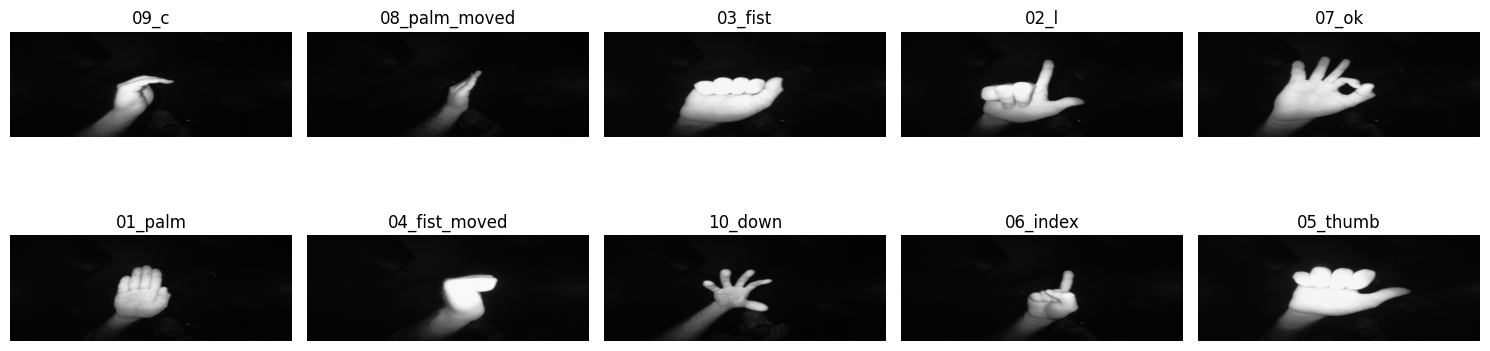

In [ ]:
def plot_images_at_intervals(images, labels, interval=200, count=10):
    plt.figure(figsize=(15, 5))

    for i in range(count):
        index = i * interval
        if index < len(images):
            img_path = images[index]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

            plt.subplot(2, 5, i+1)  # 2 rows, 5 columns, current position i+1
            plt.imshow(img)
            plt.title(labels[index])
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
plot_images_at_intervals(images, labels)

# **Converting the data to DataFrame**

In [ ]:
img_set = pd.Series(images, name="Images")
label_set = pd.Series(labels, name="labels")
data = pd.concat([img_set, label_set], axis=1)
df = pd.DataFrame(data)

In [ ]:
df.shape

(20000, 2)

In [ ]:
df.head()

,Images,labels
0,/content/leapGestRecog/06/09_c/frame_06_09_017...,09_c
1,/content/leapGestRecog/06/09_c/frame_06_09_016...,09_c
2,/content/leapGestRecog/06/09_c/frame_06_09_000...,09_c
3,/content/leapGestRecog/06/09_c/frame_06_09_020...,09_c
4,/content/leapGestRecog/06/09_c/frame_06_09_001...,09_c


In [ ]:
df.labels.value_counts()

,count
labels,
09_c,2000
08_palm_moved,2000
03_fist,2000
02_l,2000
07_ok,2000
01_palm,2000
04_fist_moved,2000
10_down,2000
06_index,2000


# **Splitting the dataset into train and test**

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(df, test_size=0.3, random_state=42)

# **Data Preprocessing**

In [ ]:
# Define the image generator with preprocessing function
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Define a function to create data generators from dataframes
def create_data_generator(dataframe, image_gen, target_size=(227, 227), color_mode='rgb', class_mode='categorical', batch_size=4, shuffle=False):
    return image_gen.flow_from_dataframe(
        dataframe=dataframe,
        x_col="Images",
        y_col="labels",
        target_size=target_size,
        color_mode=color_mode,
        class_mode=class_mode,
        batch_size=batch_size,
        shuffle=shuffle
    )

# Create data generators for train, test, and validation sets
train = create_data_generator(train_set, image_gen)
test = create_data_generator(X_test, image_gen)
val = create_data_generator(val_set, image_gen)


Found 14000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


# **AlexNet Model Building**
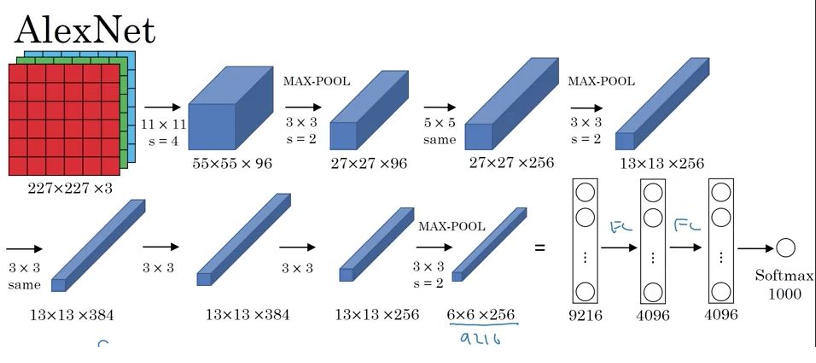

In [ ]:
model = keras.models.Sequential([
    # Convolution Layer 1
    keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding='valid', input_shape=(227, 227, 3)),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # Convolutional Layer 2
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # Convolutional Layer 3
    keras.layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'),

    # Convolutional Layer 4
    keras.layers.Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'),

    # Convolutional Layer 5
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # Flatten and Fully Connected Layers
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,322,314 (222.48 MB)

 Trainable params: 58,322,314 (222.48 MB)

 Non-trainable params: 0 (0.00 B)

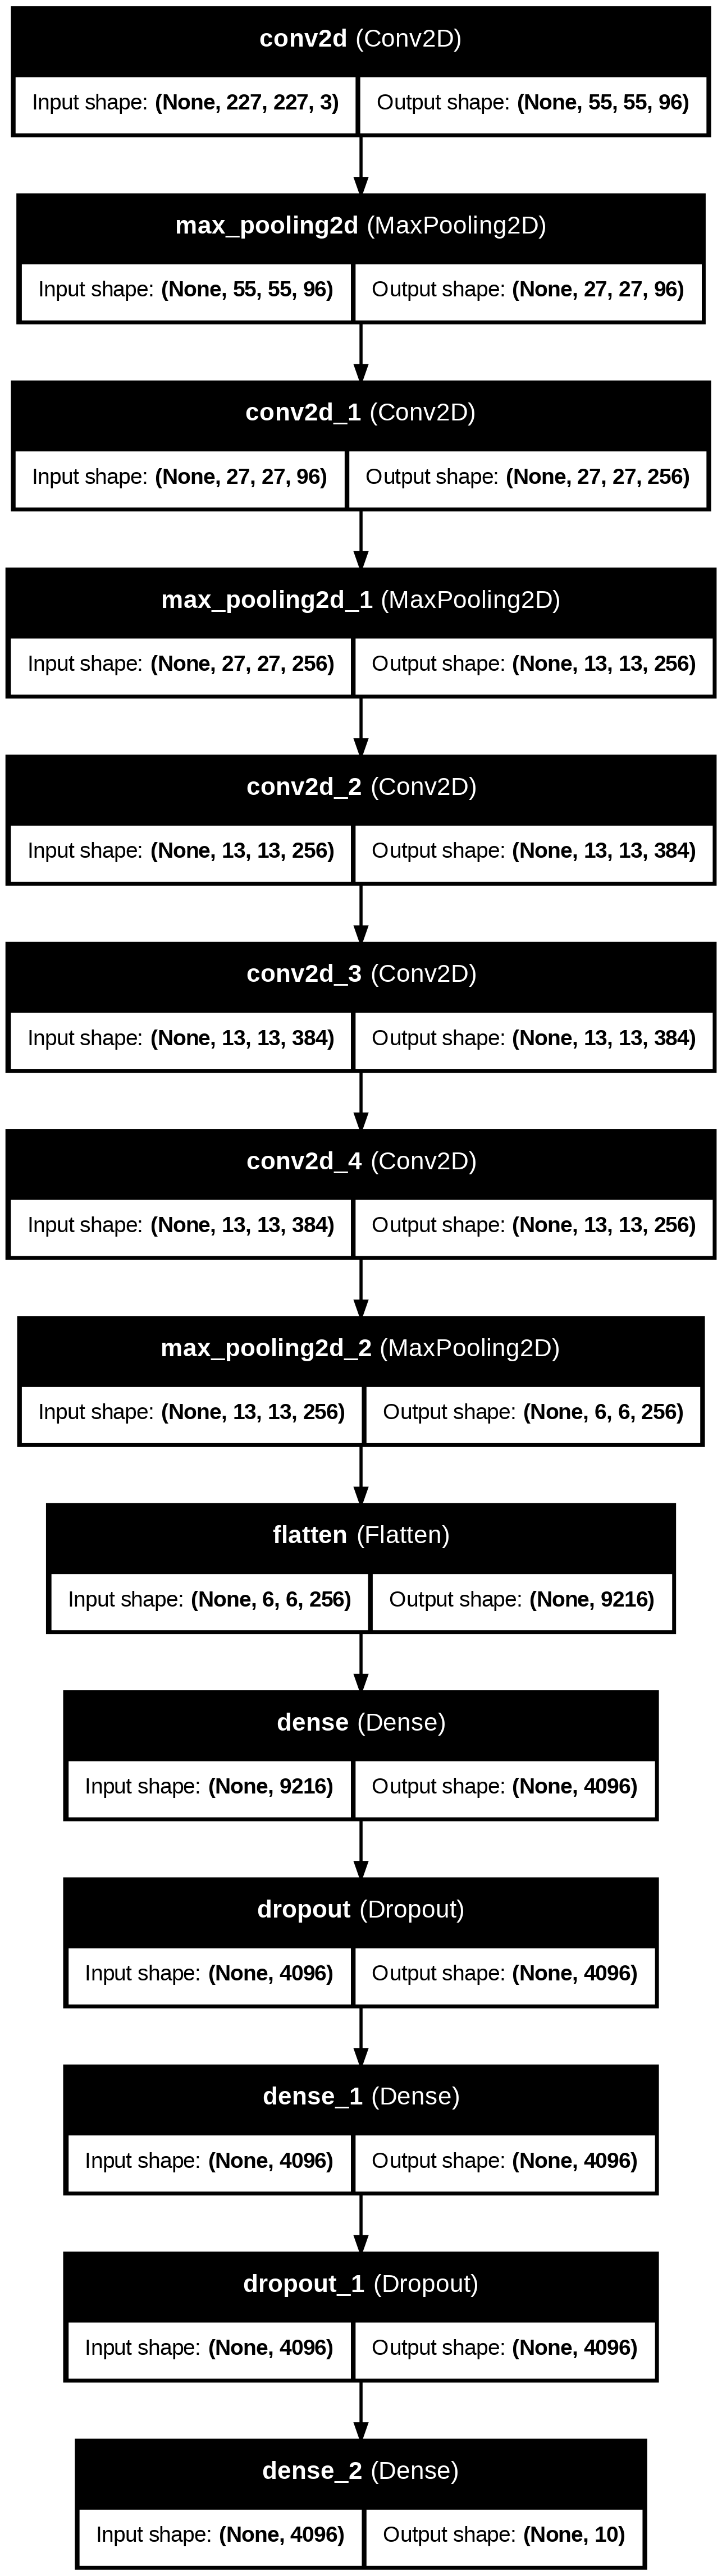

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Training the model**

In [ ]:
history = model.fit(train, epochs=1, validation_data=val, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3500/3500 ━━━━━━━━━━━━━━━━━━━━ 7387s 2s/step - accuracy: 0.2306 - loss: 2.0754 - val_accuracy: 0.8725 - val_loss: 0.3942


# **Testing the model**

In [ ]:
model.evaluate(test, verbose=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 265s 265ms/step - accuracy: 0.8720 - loss: 0.4107


[0.3922061026096344, 0.8767499923706055]

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 247s 247ms/step


In [ ]:
history.history['val_accuracy']

[0.8725000023841858]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_test = X_test.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

               precision    recall  f1-score   support

      01_palm       0.87      0.93      0.90       392
         02_l       0.94      0.94      0.94       418
      03_fist       1.00      0.66      0.79       404
04_fist_moved       0.87      0.92      0.89       403
     05_thumb       1.00      0.73      0.84       366
     06_index       0.75      0.97      0.85       410
        07_ok       0.91      0.81      0.86       377
08_palm_moved       0.75      1.00      0.86       404
         09_c       0.89      0.79      0.84       417
      10_down       0.96      1.00      0.98       409

     accuracy                           0.88      4000
    macro avg       0.89      0.87      0.87      4000
 weighted avg       0.89      0.88      0.88      4000

Accuracy of the Model: 87.7%


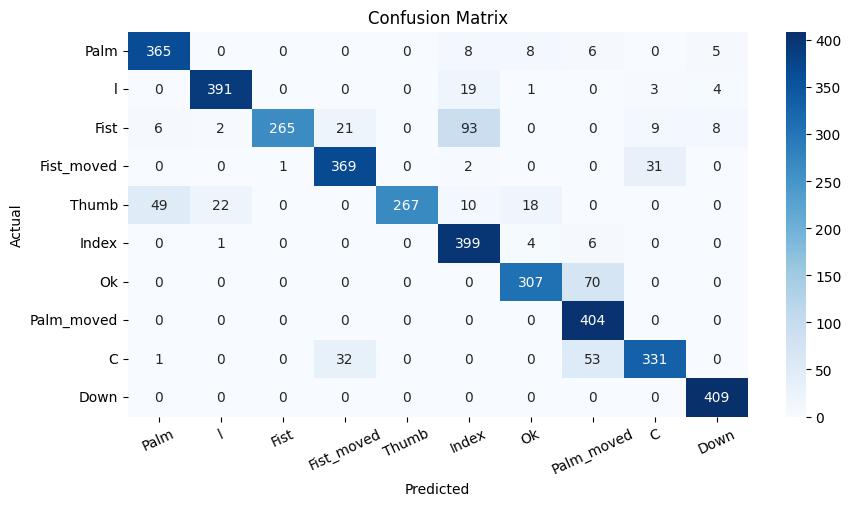

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Palm', 'l', 'Fist', 'Fist_moved', 'Thumb', 'Index', 'Ok', 'Palm_moved', 'C', 'Down']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=class_labels, rotation=25)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=class_labels, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()